# Proyecto: Predicción de Anemia en Mujeres

## 📊 Perfil del Proyecto

## Fase 1. Business Understanding

La anemia en mujeres en edad fértil representa un desafío significativo de salud pública en Perú, con una prevalencia nacional que oscila entre 30-40% según reportes del Ministerio de Salud. La detección temprana es crucial para implementar intervenciones efectivas, pero los métodos actuales de screening presentan limitaciones en cobertura y eficiencia. Este proyecto busca desarrollar un modelo predictivo que permita identificar mujeres en riesgo de anemia utilizando datos disponibles de encuestas nacionales de salud.

### 1. Objetivos
Objetivo Principal:
Desarrollar un modelo de clasificación binaria que prediga la presencia de anemia en mujeres peruanas en edad fértil (15-49 años) con un F1-Score ≥ 0.85.

#### Objetivos Específicos:

1. Identificar los cinco principales factores de riesgo asociados con anemia
2. Establecer un sistema de priorización para intervenciones de salud pública

3. Reducir los costos operativos de screening en al menos 30%

4. Proporcionar recomendaciones accionables para programas de prevención

### Criterios de Éxito
#### Métricos Técnicos:

- F1-Score: ≥ 0.85 en validación cruzada

- Precisión: ≥ 0.80

- Sensibilidad: ≥ 0.85

- AUC-ROC: ≥ 0.90

#### Métricas de Negocio:

- Identificación de al menos 5 factores de riesgo con significancia estadística

- Reducción del 30% en costos de screening mediante focalización

- Tasa de detección temprana del 80% en población de riesgo

- Validación y aceptación por parte de expertos en salud pública

## Fase 2. Data Understanding

### 📥 2. Fuentes de Datos

#### 📁 Descripción del Dataset

El proyecto utiliza dos datasets principales de encuestas de salud peruanas:

1. `RECH0.csv`: Datos demográficos y socioeconómicos de hogares

    - Registros: 37,390

    - Variables: 44 columnas

    - Período de recolección: 2024

2. `RECH5.csv`: Datos de salud y nutrición de mujeres en edad fértil

    - Registros: 38,488

    - Variables: 40 columnas

    - Período de recolección: 2024

3. `RECH23.csv`: Datos de características de vivienda
    
    - Registros: 37,390

    - Variables: 130 columnas

    - Período de recolección: 2024

#### Variables Clave Identificadas
##### Variables Demográficas (RECH0):

- `IDHOGAR`: Identificador único del hogar

- `EDAD_MUJER`: Edad de la mujer en años

- `NIVEL_EDUCATIVO`: Máximo nivel educativo alcanzado

- `REGION`: Región o departamento de residencia

- `AREA_URBANA_RURAL`: Clasificación urbano/rural

- `IDIOMA_MATERNO`: Idioma principal hablado

- `ACCESO_SERVICIOS_BASICOS`: Indicador de acceso a servicios

##### Variables de Salud (RECH5):

- `HEMOGLOBINA`: Nivel de hemoglobina en g/dL

- `IMC`: Índice de Masa Corporal

- `PESO_KG`: Peso en kilogramos

- `TALLA_CM`: Talla en centímetros

- `EMBARAZO_ACTUAL`: Estado de embarazo actual

- `SUPLEMENTOS_HIERRO`: Consumo de suplementos de hierro

- `ANEMIA_CLASIFICACION`: Clasificación actual de anemia

##### Variables de Características de Vivienda (RECH23)

- `FUENTE_AGUA_BEBER`: Fuente principal de abastecimiento de agua para tomar

- `FUENTE_AGUA_HOGAR`: Fuente principal de agua en el hogar

- `PRUEBA_YODO`: Clasificación del estado de yodo en sal

- `TIPO_SERVICIO_HIGIENICO`: Tipo de servicio higienico en el hogar

- `MARCA_SAL_USADA`: Marca de sal usada por el hogar

- `INDICE_RIQUEZA`: Clasificación de índice de riqueza

- `FACTOR_PUNTUACION_RIQUEZA`: Factor de puntuación del índice de riqueza (5 decimales)

#### Estrategia de Integración
Los datasets se unirán mediante la variable IDHOGAR, permitiendo consolidar información demográfica con datos de salud para el análisis integral.

#### Consideraciones Éticas
- Todos los datos personales están anonimizados

- Cumplimiento de la Ley de Protección de Datos Personales peruana

- Uso exclusivo para investigación en salud pública

- Aprobación del comité de ética correspondiente



In [ ]:
import pandas as pd
import numpy as np
import os

print('Ruta raíz:', os.getcwd())

df_rech0 = pd.read_csv("md-project/data/raw/968-Modulo1629/RECH0_2024.csv")
df_rech5 = pd.read_csv("md-project/data/raw/968-Modulo1638/RECH5_2024.csv")
df_rech23 = pd.read_csv("md-project/data/raw/968-Modulo1630/RECH23_2024.csv")
df_union = (df_rech0
            .merge(df_rech5, on='HHID', how='inner')
            .merge(df_rech23, on='HHID', how='inner'))
df_union = df_union.drop(columns=['ID1_x', 'ID1_y'], errors='ignore')

import json
from collections import defaultdict

dict_paths = {
    'RECH0': "md-project/data/raw/968-Modulo1629/Diccionario_RECH0.json",
    'RECH5': "md-project/data/raw/968-Modulo1638/Diccionario_RECH5.json",
    'RECH23': "md-project/data/raw/968-Modulo1630/Diccionario_RECH23.json",
    'RECHUnion': "md-project/data/Diccionario_RECHUnion.json"
}

import json

def cargar_diccionario_variables(path):
    """
    Devuelve un dict {variable: descripcion}. Usa varios posibles campos
    porque el JSON puede no tener claves uniformes.
    """
    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    mapping = {}
    for obj in data.get('variables', []):
        var = (obj.get('variable') or obj.get('valores') or obj.get('nombre') or "").strip()
        desc = (obj.get('descripcion') or obj.get('label') or obj.get('obs') or "").strip()
        if var:
            # Evita sobrescribir si ya había descripción más larga
            if var not in mapping or (desc and len(desc) > len(mapping[var])):
                mapping[var] = desc if desc else ""
    return mapping

dicc_union = cargar_diccionario_variables(dict_paths['RECHUnion'])


Ruta raíz: /opt/notebooks


In [31]:
# Resumen general Dataset RECH0

# Cargar diccionario específico RECH0
dicc_rech0 = cargar_diccionario_variables(dict_paths['RECH0'])

print("=== df_rech0.info() ===")
df_rech0.info()

# Tabla variable + descripción
meta_rech0 = (
    pd.DataFrame({'variable': df_rech0.columns})
      .assign(descripcion=lambda d: d.variable.map(dicc_rech0)
              .fillna("(sin descripción en diccionario)"))
)

print("\n=== Variables y descripciones RECH0 (primeras 40) ===")
display(meta_rech0)

print("\nshape:", df_rech0.shape)

# Head con MultiIndex (solo para visualización)
vista_rech0 = df_rech0.head(10).copy()
vista_rech0.columns = pd.MultiIndex.from_arrays(
    [vista_rech0.columns,
     [dicc_rech0.get(c, "") for c in vista_rech0.columns]],
    names=["variable", "descripcion"]
)
display(vista_rech0)

=== df_rech0.info() ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37390 entries, 0 to 37389
Data columns (total 44 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID1         37390 non-null  int64  
 1   HHID        37390 non-null  int64  
 2   HV000       37390 non-null  object 
 3   HV001       37390 non-null  int64  
 4   HV002       37390 non-null  int64  
 5   HV002A      37390 non-null  int64  
 6   HV003       37390 non-null  int64  
 7   HV004       37390 non-null  int64  
 8   HV007       37390 non-null  int64  
 9   HV008       37390 non-null  int64  
 10  HV009       37390 non-null  int64  
 11  HV010       37390 non-null  int64  
 12  HV011       37390 non-null  int64  
 13  HV012       37390 non-null  int64  
 14  HV013       37390 non-null  int64  
 15  HV014       37390 non-null  int64  
 16  HV015       37390 non-null  int64  
 17  HV017       37390 non-null  int64  
 18  HV020       37390 non-null  int64  
 19  H

,variable,descripcion
0,ID1,Año
1,HHID,Identificacion Cuestionario del Hogar
2,HV000,Código del país
3,HV001,Conglomerado
4,HV002,Vivienda
5,HV002A,Hogar
6,HV003,Número de orden del Informante del cuestionari...
7,HV004,Unidad última de muestreo
8,HV007,Año de entrevista
9,HV008,Fecha de entrevista meses (CMC)



shape: (37390, 44)


variable,ID1,HHID,HV000,HV001,HV002,HV002A,HV003,HV004,HV007,HV008,...,HV043,HV044,UBIGEO,HV022,HV005,CODCCPP,NOMCCPP,LATITUDY,LONGITUDX,NCONGLOME1
descripcion,Año,Identificacion Cuestionario del Hogar,Código del país,Conglomerado,Vivienda,Hogar,Número de orden del Informante del cuestionario del hogar,Unidad última de muestreo,Año de entrevista,Fecha de entrevista meses (CMC),...,Hogares seleccionados para el módulo de mujeres de estado,Selección para el módulo de violencia familiar,Código de Ubicación Gegráfica,Estrato,Factor de ponderación,Codigo de Centro Poblado,Nombre del Centro Poblado,Latitud del conglomerado,Longitud del conglomerado,Número de Conglomerado (proveniente del marco)
0,2024,325502001,PE6,3255,20,1,0,3255,2024,1493,...,0,1,10101,2,0,1,CHACHAPOYAS,-6.225832,-77.861302,7076
1,2024,325503101,PE6,3255,31,1,2,3255,2024,1493,...,0,1,10101,2,74497,1,CHACHAPOYAS,-6.225832,-77.861302,7076
2,2024,325503901,PE6,3255,39,1,1,3255,2024,1493,...,0,1,10101,2,607697,1,CHACHAPOYAS,-6.225832,-77.861302,7076
3,2024,325504001,PE6,3255,40,1,1,3255,2024,1493,...,0,1,10101,2,607697,1,CHACHAPOYAS,-6.225832,-77.861302,7076
4,2024,325504701,PE6,3255,47,1,2,3255,2024,1493,...,0,1,10101,2,74497,1,CHACHAPOYAS,-6.225832,-77.861302,7076
5,2024,325505001,PE6,3255,50,1,1,3255,2024,1493,...,0,1,10101,2,74497,1,CHACHAPOYAS,-6.225832,-77.861302,7076
6,2024,325505301,PE6,3255,53,1,1,3255,2024,1493,...,0,1,10101,2,607697,1,CHACHAPOYAS,-6.225832,-77.861302,7076
7,2024,325508901,PE6,3255,89,1,1,3255,2024,1493,...,0,1,10101,2,74497,1,CHACHAPOYAS,-6.225832,-77.861302,7076
8,2024,325509301,PE6,3255,93,1,2,3255,2024,1493,...,0,1,10101,2,607697,1,CHACHAPOYAS,-6.225832,-77.861302,7076


In [32]:
# Resumen general Dataset RECH5
# Cargar diccionario específico RECH5
dicc_rech5 = cargar_diccionario_variables(dict_paths['RECH5'])

print("=== df_rech5.info() ===")
df_rech5.info()

# Tabla variable + descripción
meta_rech5 = (
    pd.DataFrame({'variable': df_rech5.columns})
      .assign(descripcion=lambda d: d.variable.map(dicc_rech5)
              .fillna("(sin descripción en diccionario)"))
)

print("\n=== Variables y descripciones RECH5 ===")
display(meta_rech5)

print("\nshape:", df_rech5.shape)

# Head con MultiIndex (solo para visualización)
vista_rech5 = df_rech5.head(10).copy()
vista_rech5.columns = pd.MultiIndex.from_arrays(
    [vista_rech5.columns,
     [dicc_rech5.get(c, "") for c in vista_rech5.columns]],
    names=["variable", "descripcion"]
)
display(vista_rech5)

=== df_rech5.info() ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38488 entries, 0 to 38487
Data columns (total 40 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID1     38488 non-null  int64 
 1   HHID    38488 non-null  int64 
 2   HA0     38488 non-null  int64 
 3   HA1     38488 non-null  int64 
 4   HA2     38488 non-null  int64 
 5   HA3     38488 non-null  int64 
 6   HA4     38488 non-null  int64 
 7   HA5     38488 non-null  int64 
 8   HA6     38488 non-null  int64 
 9   HA11    38488 non-null  int64 
 10  HA12    38488 non-null  int64 
 11  HA12A   38488 non-null  int64 
 12  HA12B   38488 non-null  int64 
 13  HA13    38488 non-null  int64 
 14  HA32    38488 non-null  int64 
 15  HA33    38488 non-null  int64 
 16  HA35    38488 non-null  int64 
 17  HA40    38488 non-null  int64 
 18  HA41    38488 non-null  int64 
 19  HA50    38488 non-null  int64 
 20  HA51    38488 non-null  object
 21  HA52    38488 non-null  int64 
 22

,variable,descripcion
0,ID1,Año
1,HHID,Identificación de caso
2,HA0,Número de orden en hogar
3,HA1,Edad de la mujer en años
4,HA2,Peso en kilogramos (1 decimal)
5,HA3,Talla en centímetros (1 decimal)
6,HA4,Talla/Edad percentil en que se encuentra
7,HA5,Talla/Edad Desviación Estándar
8,HA6,Talla/Edad porcentaje respecto a la mediana de...
9,HA11,Peso/Talla desvio estándar (DHS)



shape: (38488, 40)


variable,ID1,HHID,HA0,HA1,HA2,HA3,HA4,HA5,HA6,HA11,...,HA60,HA61,HA62,HA63,HA64,HA65,HA66,HA67,HA68,HA69
descripcion,Año,Identificación de caso,Número de orden en hogar,Edad de la mujer en años,Peso en kilogramos (1 decimal),Talla en centímetros (1 decimal),Talla/Edad percentil en que se encuentra,Talla/Edad Desviación Estándar,Talla/Edad porcentaje respecto a la mediana de referencia,Peso/Talla desvio estándar (DHS),...,Estado civil,Lea la declaración de consentimiento (VIH),Número de identificación de la muestra de sangre,Resultado de la medición (VIH),Consentimiento para pruebas adicionales,Resultado de la entrevista individual a la mujer,El nivel educativo más alto aprobado de la mujer,El año más alto de educación de la mujer,Nivel educativo más alto (CS para el informe preliminar y final),Peso del VIH (6 decimales)
0,2024,325503101,2,38,704,1525,301,-188,9315,108,...,,,,,,1,2,5,2,
1,2024,325503101,4,15,541,1518,591,-156,9355,16,...,,,,,,1,2,3,2,
2,2024,325503901,2,17,498,1602,2931,-54,9798,-101,...,,,,,,1,2,5,2,
3,2024,325504701,2,32,653,1443,6,-325,8814,146,...,,,,,,1,2,5,2,
4,2024,325505001,1,36,689,1486,57,-253,9077,122,...,,,,,,1,1,6,1,
5,2024,325505301,1,32,729,1570,1303,-112,9590,127,...,,,,,,1,1,6,1,
6,2024,325508901,2,34,573,1533,405,-175,9364,-11,...,,,,,,1,2,5,2,
7,2024,325509301,1,24,669,1547,655,-151,9450,139,...,,,,,,1,3,5,3,
8,2024,325509301,2,18,676,1515,203,-205,9254,171,...,,,,,,1,3,1,3,


In [33]:
# Resumen general Dataset RECH23
# Cargar diccionario específico RECH23
dicc_rech23 = cargar_diccionario_variables(dict_paths['RECH23'])

print("=== df_rech23.info() ===")
df_rech23.info()

# Tabla variable + descripción
meta_rech23 = (
    pd.DataFrame({'variable': df_rech23.columns})
      .assign(descripcion=lambda d: d.variable.map(dicc_rech23)
              .fillna("(sin descripción en diccionario)"))
)

print("\n=== Variables y descripciones RECH23 ===")
display(meta_rech23)

print("\nshape:", df_rech23.shape)

# Head con MultiIndex (solo para visualización)
vista_rech23 = df_rech23.head(10).copy()
vista_rech23.columns = pd.MultiIndex.from_arrays(
    [vista_rech23.columns,
     [dicc_rech23.get(c, "") for c in vista_rech23.columns]],
    names=["variable", "descripcion"]
)
display(vista_rech23)

=== df_rech23.info() ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37390 entries, 0 to 37389
Columns: 130 entries, ID1 to HV271
dtypes: int64(8), object(122)
memory usage: 37.1+ MB

=== Variables y descripciones RECH23 ===


,variable,descripcion
0,ID1,Año
1,HHID,Identificación Cuestionario del Hogar
2,HV201,¿Cuál es la fuente principal de abastecimiento...
3,HV202,¿Cuál es la fuente principal de abastecimiento...
4,HV204,"¿Cuánto tiempo se demora en ir, recoger agua y..."
...,...,...
125,SH227,Prueba de cloro
126,QH227A,La muestra fue tomada por:
127,QH227B,La muestra del agua se extrajo del:
128,HV270,Índice de riqueza



shape: (37390, 130)


variable,ID1,HHID,HV201,HV202,HV204,HV205,HV206,HV207,HV208,HV209,...,SH78,SH79,SH224,SH225U,SH225,SH227,QH227A,QH227B,HV270,HV271
descripcion,Año,Identificación Cuestionario del Hogar,¿Cuál es la fuente principal de abastecimiento de agua para tomar o beber?,¿Cuál es la fuente principal de abastecimiento de agua en su hogar?,"¿Cuánto tiempo se demora en ir, recoger agua y volver?",¿Qué tipo de servicio higiénico tiene su hogar?,¿Tiene electricidad en su hogar?,Su hogar ¿tiene radio?,Su hogar ¿tiene televisor?,Su hogar ¿tiene refrigeradora/congeladora?,...,Algún miembro de su hogar es dueño de tierras agrícolas,Cuántas hectáreas (1 decimal),Prueba de Yodo,Visualización de la bolsa de sal,Marca de sal usada por el hogar,Prueba de cloro,La muestra fue tomada por:,La muestra del agua se extrajo del:,Índice de riqueza,Factor de puntuación del índice de riqueza (5 decimales)
0,2024,325502001,,,,,,,,,...,,,,,,,,,,
1,2024,325503101,11,,996,22,1,0,0,0,...,0,,9,,,2,1,1,2,-.224175006493913
2,2024,325503901,11,,996,11,1,0,0,0,...,0,,9,,,3,1,1,3,.366367930920724
3,2024,325504001,11,,996,22,1,1,0,0,...,0,,9,,,3,1,1,1,-.76953388723092
4,2024,325504701,71,11,996,11,1,1,1,1,...,0,,9,,,5,,,2,.0566849954924239
5,2024,325505001,11,,996,11,1,0,1,0,...,0,,9,,,1,1,1,2,-.256260959044164
6,2024,325505301,11,,996,11,1,0,1,0,...,0,,9,,,3,1,1,2,-.17238395918053
7,2024,325508901,11,,996,11,1,1,0,0,...,0,,9,,,1,1,1,3,.563507474984082
8,2024,325509301,11,,996,11,1,0,1,0,...,0,,9,,,3,1,1,3,.445810583037222


In [34]:
# Resumen general Dataset RECH0-H5-H23
# Cargar diccionario específico RECH0-H5-H23
dicc_union = cargar_diccionario_variables(dict_paths['RECHUnion'])

print("=== df_union.info() ===")
df_union.info()

# Tabla variable + descripción
meta_union = (
    pd.DataFrame({'variable': df_union.columns})
      .assign(descripcion=lambda d: d.variable.map(dicc_union)
              .fillna("(sin descripción en diccionario)"))
)

print("\n=== Variables y descripciones REC0-H5-H23 ===")
display(meta_union)

print("\nshape:", df_union.shape)

# Head con MultiIndex para unión
vista_union = df_union.head(10).copy()
vista_union.columns = pd.MultiIndex.from_arrays(
    [vista_union.columns, [dicc_union.get(c, "") for c in vista_union.columns]],
    names=["variable", "descripcion"]
)
display(vista_union)

=== df_union.info() ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38488 entries, 0 to 38487
Columns: 210 entries, HHID to HV271
dtypes: float64(2), int64(72), object(136)
memory usage: 61.7+ MB

=== Variables y descripciones REC0-H5-H23 ===


,variable,descripcion
0,HHID,Identificacion Cuestionario del Hogar
1,HV000,Código del país
2,HV001,Conglomerado
3,HV002,Vivienda
4,HV002A,Hogar
...,...,...
205,SH227,Prueba de cloro
206,QH227A,La muestra fue tomada por:
207,QH227B,La muestra del agua se extrajo del:
208,HV270,Índice de riqueza



shape: (38488, 210)


variable,HHID,HV000,HV001,HV002,HV002A,HV003,HV004,HV007,HV008,HV009,...,SH78,SH79,SH224,SH225U,SH225,SH227,QH227A,QH227B,HV270,HV271
descripcion,Identificacion Cuestionario del Hogar,Código del país,Conglomerado,Vivienda,Hogar,Número de orden del Informante del cuestionario del hogar,Unidad última de muestreo,Año de entrevista,Fecha de entrevista meses (CMC),Total de personas en el hogar,...,Algún miembro de su hogar es dueño de tierras agrícolas,Cuántas hectáreas (1 decimal),Prueba de Yodo,Visualización de la bolsa de sal,Marca de sal usada por el hogar,Prueba de cloro,La muestra fue tomada por:,La muestra del agua se extrajo del:,Índice de riqueza,Factor de puntuación del índice de riqueza (5 decimales)
0,325503101,PE6,3255,31,1,2,3255,2024,1493,4,...,0,,9,,,2,1,1,2,-.224175006493913
1,325503101,PE6,3255,31,1,2,3255,2024,1493,4,...,0,,9,,,2,1,1,2,-.224175006493913
2,325503901,PE6,3255,39,1,1,3255,2024,1493,2,...,0,,9,,,3,1,1,3,.366367930920724
3,325504701,PE6,3255,47,1,2,3255,2024,1493,4,...,0,,9,,,5,,,2,.0566849954924239
4,325505001,PE6,3255,50,1,1,3255,2024,1493,3,...,0,,9,,,1,1,1,2,-.256260959044164
5,325505301,PE6,3255,53,1,1,3255,2024,1493,2,...,0,,9,,,3,1,1,2,-.17238395918053
6,325508901,PE6,3255,89,1,1,3255,2024,1493,4,...,0,,9,,,1,1,1,3,.563507474984082
7,325509301,PE6,3255,93,1,2,3255,2024,1493,2,...,0,,9,,,3,1,1,3,.445810583037222
8,325509301,PE6,3255,93,1,2,3255,2024,1493,2,...,0,,9,,,3,1,1,3,.445810583037222


### 📊 3. Descriptive analysis

#### 3.1 Análisis descriptivo

In [35]:
#Resumen estadístico de todas las variables (describe()).

desc_union = df_union.describe(include="all").T

# Crear MultiIndex con variable y descripción para el resumen estadístico
desc_union_desc = desc_union.copy()
desc_union_desc.index = pd.MultiIndex.from_arrays(
    [desc_union_desc.index,
     [dicc_union.get(var, "(sin descripción en diccionario)") for var in desc_union_desc.index]],
    names=["variable", "descripcion"]
)
display(desc_union_desc)

,,count,unique,top,freq,mean,std,min,25%,50%,75%,max
variable,descripcion,,,,,,,,,,,
HHID,Identificacion Cuestionario del Hogar,38488.0,NaN,NaN,NaN,488812022.104188,94242177.32956,325503101.0,406309776.0,489104251.0,570002201.0,705708801.0
HV000,Código del país,38488,1,PE6,38488,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HV001,Conglomerado,38488.0,NaN,NaN,NaN,4888.05581,942.423163,3255.0,4063.0,4891.0,5700.0,7057.0
HV002,Vivienda,38488.0,NaN,NaN,NaN,64.401242,45.337252,1.0,28.0,57.0,93.0,273.0
HV002A,Hogar,38488.0,NaN,NaN,NaN,1.019694,0.165571,1.0,1.0,1.0,1.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
SH227,Prueba de cloro,38488,7,3,14134,NaN,NaN,NaN,NaN,NaN,NaN,NaN
QH227A,La muestra fue tomada por:,38488,3,1,20384,NaN,NaN,NaN,NaN,NaN,NaN,NaN
QH227B,La muestra del agua se extrajo del:,38488,7,1,19024,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
# Separar los datos segú sus Tipos de variables (numéricas, categóricas). fechas se considera como cat aunque también puedes separr
numeric_data = df_union.select_dtypes(include=[np.number])
categor_data = df_union.select_dtypes(exclude=[np.number])
print ("There are {} numeric and {} categorical columns in train data".format(numeric_data.shape[1],categor_data.shape[1]))

There are 74 numeric and 136 categorical columns in train data


In [42]:
#### 3.2 Clasificación y conversión de tipos de variables

# Crear copia del dataframe para trabajar
df_typed = df_union.copy()

# Diccionarios para clasificar variables
clasificacion_variables = {
    'categorica_dicotomica': [],
    'categorica_nominal_politomica': [],
    'categorica_ordinal_politomica': [],
    'numerica_discreta': [],
    'numerica_continua': [],
    'texto_identificador': []
}

# Cargar el diccionario JSON completo para clasificación
with open(dict_paths['RECHUnion'], 'r', encoding='utf-8') as f:
    diccionario_completo_union = json.load(f)

# Función para analizar y clasificar variables
def clasificar_variable(nombre_var, diccionario_info, df_datos):
    """Clasifica una variable según su naturaleza real"""

    # Obtener info del diccionario
    var_info = None
    for var in diccionario_info['variables']:
        if var.get('variable') == nombre_var:
            var_info = var
            break

    if var_info is None:
        return 'sin_info'

    tipo_dict = var_info.get('tipo', '')
    rango = var_info.get('rango', '')
    descripcion = var_info.get('descripcion', '').lower()
    alternativas = var_info.get('alternativas', [])

    # Análisis de los datos reales
    serie = df_datos[nombre_var]
    valores_unicos = serie.nunique()
    valores_no_nulos = serie.dropna().unique()

    # Variables de texto/identificador
    if tipo_dict == 'A' or nombre_var in ['HHID', 'HV000', 'NOMCCPP', 'CODCCPP']:
        return 'texto_identificador'

    # Variables numéricas continuas (medidas físicas)
    if any(keyword in nombre_var.lower() for keyword in ['ha2', 'ha3', 'ha40', 'ha53', 'ha56']):
        return 'numerica_continua'

    # Variables de coordenadas y factores
    if any(keyword in nombre_var for keyword in ['LATITUD', 'LONGITUD', 'HV040', 'HV005', 'HV028', 'HV033', 'HV271']):
        return 'numerica_continua'

    # Variables de tiempo/área continuas
    if any(keyword in nombre_var for keyword in ['HV204', 'SH79', 'SH225']):
        return 'numerica_continua'

    # Variables categóricas dicotómicas (2 valores únicos)
    if valores_unicos == 2 and all(v in [0, 1] or v in [1, 2] for v in valores_no_nulos if pd.notna(v)):
        return 'categorica_dicotomica'

    # Variables categóricas ordinales (niveles, severidad, educación)
    if any(keyword in descripcion for keyword in ['nivel', 'grado', 'severidad', 'clasificacion', 'indice']):
        if 'educativo' in descripcion or 'educacion' in descripcion:
            return 'categorica_ordinal_politomica'
        if 'anemia' in descripcion or 'severidad' in descripcion:
            return 'categorica_ordinal_politomica'
        if 'riqueza' in descripcion and valores_unicos <= 10:
            return 'categorica_ordinal_politomica'

    # Variables de conteo (discretas)
    if any(keyword in descripcion for keyword in ['numero de', 'total de', 'cantidad']):
        return 'numerica_discreta'

    # Análisis por rango del diccionario
    if isinstance(rango, str):
        if any(patron in rango for patron in ['0:1', '1:2']):
            return 'categorica_dicotomica'
        if any(patron in rango for patron in ['1:3', '1:4', '1:5', '0:3', '0:4']):
            # Verificar si es ordinal por descripción
            if any(keyword in descripcion for keyword in ['nivel', 'grado', 'tipo', 'clasificacion']):
                return 'categorica_ordinal_politomica'
            else:
                return 'categorica_nominal_politomica'

    # Variables con muchos valores únicos y tipo numérico
    if tipo_dict == 'N' and valores_unicos > 20:
        # Si contiene decimales o es muy variable, es continua
        if any('.' in str(v) for v in valores_no_nulos[:10] if pd.notna(v)):
            return 'numerica_continua'
        # Si son enteros con rango grande, podría ser discreta
        elif valores_unicos > 50:
            return 'numerica_discreta'

    # Variables categóricas nominales (códigos, tipos, fuentes)
    if any(keyword in descripcion for keyword in ['tipo de', 'fuente', 'marca', 'codigo']):
        return 'categorica_nominal_politomica'

    # Por defecto, según número de valores únicos
    if valores_unicos <= 2:
        return 'categorica_dicotomica'
    elif valores_unicos <= 10:
        return 'categorica_nominal_politomica'
    else:
        return 'numerica_discreta'

# Clasificar todas las variables
resultados_clasificacion = []

for columna in df_typed.columns:
    tipo_clasificado = clasificar_variable(columna, diccionario_completo_union, df_typed)

    # Agregar a la lista correspondiente
    clasificacion_variables[tipo_clasificado].append(columna)

    # Guardar resultado para display
    var_info = dicc_union.get(columna, "Sin descripción")
    valores_unicos = df_typed[columna].nunique()

    resultados_clasificacion.append({
        'variable': columna,
        'tipo_clasificado': tipo_clasificado,
        'descripcion': var_info,
        'valores_unicos': valores_unicos,
        'dtype_actual': str(df_typed[columna].dtype)
    })

# Aplicar conversiones de tipo
print("=== APLICANDO CONVERSIONES DE TIPO ===")

# 1. Variables categóricas dicotómicas
for var in clasificacion_variables['categorica_dicotomica']:
    df_typed[var] = df_typed[var].astype('category')

# 2. Variables categóricas nominales politómicas
for var in clasificacion_variables['categorica_nominal_politomica']:
    df_typed[var] = df_typed[var].astype('category')

# 3. Variables categóricas ordinales politómicas
for var in clasificacion_variables['categorica_ordinal_politomica']:
    # Para ordinales, podemos especificar el orden si es conocido
    df_typed[var] = df_typed[var].astype('category')

# 4. Variables numéricas discretas
for var in clasificacion_variables['numerica_discreta']:
    df_typed[var] = pd.to_numeric(df_typed[var], errors='coerce').astype('Int64')

# 5. Variables numéricas continuas (aplicar escalado si es necesario)
for var in clasificacion_variables['numerica_continua']:
    if var in ['HA2', 'HA3', 'HA53', 'HA56', 'HA56A']:  # Variables con factor /10
        df_typed[var] = pd.to_numeric(df_typed[var], errors='coerce') / 10
    elif var == 'HA40':  # IMC con factor /100
        df_typed[var] = pd.to_numeric(df_typed[var], errors='coerce') / 100
    else:
        df_typed[var] = pd.to_numeric(df_typed[var], errors='coerce')

# Crear DataFrame para display
df_clasificacion = pd.DataFrame(resultados_clasificacion)

print("\n=== RESUMEN DE CLASIFICACIÓN Y CONVERSIÓN DE VARIABLES ===")
display(df_clasificacion)

print("\n=== RESUMEN POR TIPO ===")
resumen_tipos = df_clasificacion['tipo_clasificado'].value_counts()
display(resumen_tipos.to_frame('cantidad'))

print("\n=== VARIABLES POR TIPO DETALLADO ===")

# Crear DataFrames separados para cada tipo de variable
for tipo, variables in clasificacion_variables.items():
    if variables:
        # Crear DataFrame para este tipo específico
        df_tipo = []
        for var in variables:
            desc = dicc_union.get(var, "Sin descripción")
            valores_unicos = df_typed[var].nunique()
            tipo_dato = str(df_typed[var].dtype)

            df_tipo.append({
                'Variable': var,
                'Descripción': desc,
                'Valores_Únicos': valores_unicos,
                'Tipo_Dato': tipo_dato
            })

        df_variables_tipo = pd.DataFrame(df_tipo)

        print(f"\n=== {tipo.upper().replace('_', ' ')} ({len(variables)} variables) ===")
        display(df_variables_tipo)

print(f"\n=== TIPOS DE DATOS DESPUÉS DE CONVERSIÓN ===")
tipos_datos = df_typed.dtypes.value_counts().reset_index()
tipos_datos.columns = ['Tipo_de_Dato', 'Cantidad']
display(tipos_datos)

# Crear diccionario con DataFrames por tipo (opcional, para uso posterior)
dataframes_por_tipo = {}
for tipo, variables in clasificacion_variables.items():
    if variables:
        df_tipo = []
        for var in variables:
            desc = dicc_union.get(var, "Sin descripción")
            valores_unicos = df_typed[var].nunique()
            tipo_dato = str(df_typed[var].dtype)

            df_tipo.append({
                'Variable': var,
                'Descripción': desc,
                'Valores_Únicos': valores_unicos,
                'Tipo_Dato': tipo_dato
            })

        dataframes_por_tipo[tipo] = pd.DataFrame(df_tipo)

print("\n=== DataFrames creados para cada tipo ===")
for tipo, df in dataframes_por_tipo.items():
    print(f"- {tipo}: {len(df)} variables")



=== APLICANDO CONVERSIONES DE TIPO ===

=== RESUMEN DE CLASIFICACIÓN Y CONVERSIÓN DE VARIABLES ===

=== RESUMEN DE CLASIFICACIÓN Y CONVERSIÓN DE VARIABLES ===


,variable,tipo_clasificado,descripcion,valores_unicos,dtype_actual
0,HHID,texto_identificador,Identificacion Cuestionario del Hogar,27385,int64
1,HV000,texto_identificador,Código del país,1,object
2,HV001,categorica_nominal_politomica,Conglomerado,3253,int64
3,HV002,numerica_discreta,Vivienda,256,int64
4,HV002A,categorica_nominal_politomica,Hogar,5,int64
...,...,...,...,...,...
205,SH227,categorica_nominal_politomica,Prueba de cloro,7,object
206,QH227A,categorica_dicotomica,La muestra fue tomada por:,3,object
207,QH227B,categorica_nominal_politomica,La muestra del agua se extrajo del:,7,object
208,HV270,categorica_nominal_politomica,Índice de riqueza,5,object



=== RESUMEN POR TIPO ===


,cantidad
tipo_clasificado,
categorica_dicotomica,116
categorica_nominal_politomica,32
numerica_discreta,30
numerica_continua,20
texto_identificador,7
categorica_ordinal_politomica,5



=== VARIABLES POR TIPO DETALLADO ===

=== CATEGORICA DICOTOMICA (116 variables) ===


,Variable,Descripción,Valores_Únicos,Tipo_Dato
0,HV007,Año de entrevista,1,category
1,HV010,Número de mujeres elegibles para entrevista in...,8,category
2,HV011,Número de hombres elegibles por hogar,1,category
3,HV015,Resultado de la entrevista en el hogar,1,category
4,HV020,Muestra de alguna vez en union,1,category
...,...,...,...,...
111,SH76D,Ventanas con malla,3,category
112,SH76E,Ventanas con cortinas/persianas,3,category
113,SH77F,"Otro tipo de transporte (caballos, peque-peque...",2,category
114,SH78,Algún miembro de su hogar es dueño de tierras ...,2,category



=== CATEGORICA NOMINAL POLITOMICA (32 variables) ===


,Variable,Descripción,Valores_Únicos,Tipo_Dato
0,HV001,Conglomerado,3253,category
1,HV002A,Hogar,5,category
2,HV004,Unidad última de muestreo,3253,category
3,HV014,Número de niños menores de 5 años,6,category
4,HV017,Número de visitas,5,category
5,HV021,Unidad de muestreo primario (conglomerado),3253,category
6,HV026,Lugar de residencia,4,category
7,HV035,Número de niños elegibles para altura y peso,6,category
8,HV041,Número de mujeres con medición de peso y talla,8,category
9,HA13,Resultado de medición de la entrevistada,5,category



=== CATEGORICA ORDINAL POLITOMICA (5 variables) ===


,Variable,Descripción,Valores_Únicos,Tipo_Dato
0,HA57,Nivel de anemia RM 363-2022-MINSA,5,category
1,HA57A,Nivel de Anemia NUEVA DIRECTRIZ OMS 2024/RM 25...,5,category
2,HA66,El nivel educativo más alto aprobado de la mujer,5,category
3,HA68,Nivel educativo más alto (CS para el informe p...,5,category
4,SH49,Tipo de envase o recipiente,6,category



=== NUMERICA DISCRETA (30 variables) ===


,Variable,Descripción,Valores_Únicos,Tipo_Dato
0,HV002,Vivienda,256,Int64
1,HV003,Número de orden del Informante del cuestionari...,13,Int64
2,HV008,Fecha de entrevista meses (CMC),12,Int64
3,HV009,Total de personas en el hogar,19,Int64
4,HV012,Número de miembros de jure (residentes habitua...,19,Int64
5,HV013,Número de miembros de facto (personas que durm...,20,Int64
6,HA1,Edad de la mujer en años,38,Int64
7,HA4,Talla/Edad percentil en que se encuentra,3141,Int64
8,HA5,Talla/Edad Desviación Estándar,614,Int64
9,HA6,Talla/Edad porcentaje respecto a la mediana de...,1700,Int64



=== NUMERICA CONTINUA (20 variables) ===


,Variable,Descripción,Valores_Únicos,Tipo_Dato
0,HV028,Peso de muestra masculino,0,float64
1,HV033,Ultimate area selection prob.,0,float64
2,HV040,Altitud del conglomerado en metros,1631,int64
3,HV005,Factor de ponderación,6146,int64
4,LATITUDY,Latitud del conglomerado,4035,float64
5,LONGITUDX,Longitud del conglomerado,4035,float64
6,HA2,Peso en kilogramos (1 decimal),909,float64
7,HA3,Talla en centímetros (1 decimal),432,float64
8,HA32,Fecha de nacimiento (cmc),467,int64
9,HA33,Fecha de información completa,2,int64



=== TEXTO IDENTIFICADOR (7 variables) ===


,Variable,Descripción,Valores_Únicos,Tipo_Dato
0,HHID,Identificacion Cuestionario del Hogar,27385,int64
1,HV000,Código del país,1,object
2,UBIGEO,Código de Ubicación Gegráfica,925,int64
3,CODCCPP,Codigo de Centro Poblado,164,int64
4,NOMCCPP,Nombre del Centro Poblado,1973,object
5,NCONGLOME1,Número de Conglomerado (proveniente del marco),3253,int64
6,HA62,Número de identificación de la muestra de sangre,1,object



=== TIPOS DE DATOS DESPUÉS DE CONVERSIÓN ===


,Tipo_de_Dato,Cantidad
0,category,39
1,category,38
2,Int64,30
3,float64,14
4,category,12
5,int64,10
6,category,7
7,category,4
8,category,3
9,category,3



=== DataFrames creados para cada tipo ===
- categorica_dicotomica: 116 variables
- categorica_nominal_politomica: 32 variables
- categorica_ordinal_politomica: 5 variables
- numerica_discreta: 30 variables
- numerica_continua: 20 variables
- texto_identificador: 7 variables


In [ ]:
# Separar variables categóricas y numéricas
variables_categoricas = (clasificacion_variables['categorica_dicotomica'] +
                        clasificacion_variables['categorica_nominal_politomica'] +
                        clasificacion_variables['categorica_ordinal_politomica'])

variables_numericas = (clasificacion_variables['numerica_discreta'] +
                      clasificacion_variables['numerica_continua'])

# Crear DataFrames separados
df_categoricas = df_typed[variables_categoricas].copy()
df_numericas = df_typed[variables_numericas].copy()

# Resumen
resumen_data = pd.DataFrame({
    'Tipo': ['Categóricas', 'Numéricas', 'Total'],
    'Variables': [len(variables_categoricas), len(variables_numericas), len(df_typed.columns)],
    'Shape': [str(df_categoricas.shape), str(df_numericas.shape), str(df_typed.shape)]
})

display(resumen_data)

,Tipo,Variables,Shape
0,Categóricas,153,"(38488, 153)"
1,Numéricas,50,"(38488, 50)"
2,Total,210,"(38488, 210)"


#### 3.2 Análisis descriptivo (gráficos)

Valores únicos en HA57A: Index([1, 2, 3, 4, 9], dtype='int64')


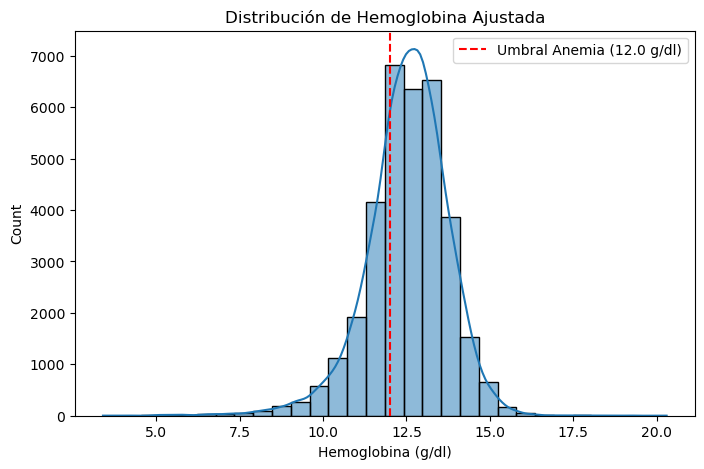

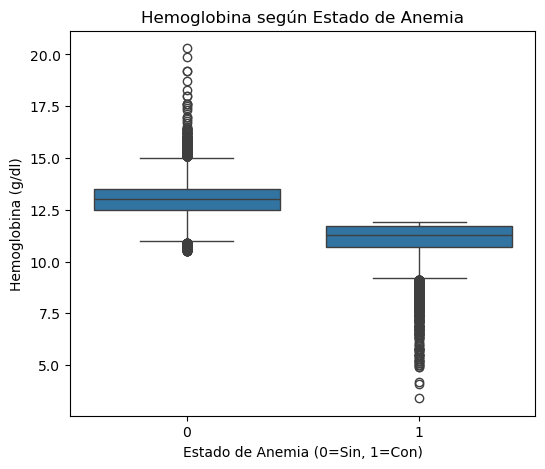

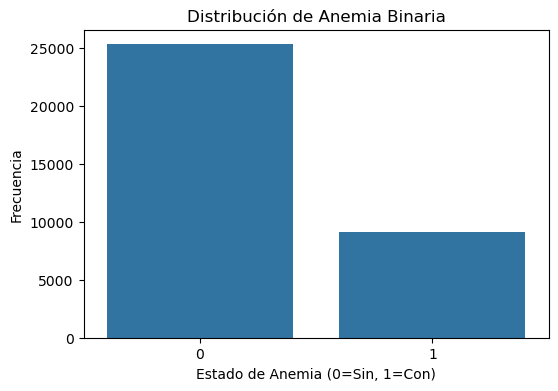

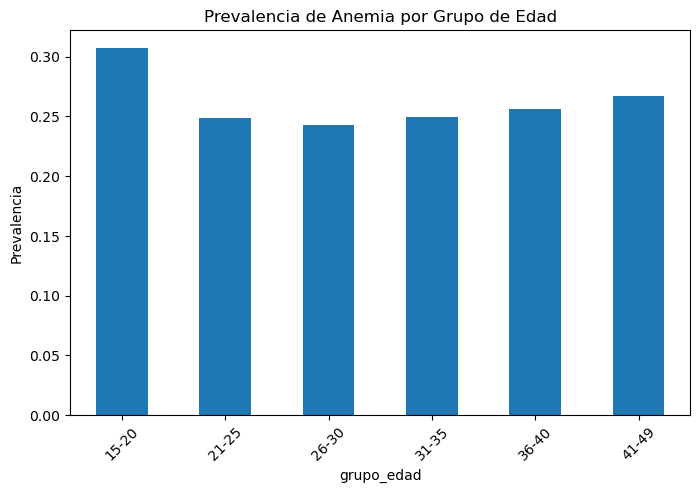

Verificación de conversión de anemia:


,Sin anemia (0),Con anemia (1),Total
Grave (1),0,152,152
Moderado (2),0,2700,2700
Leve (3),0,6311,6311
Sin anemia (4),25319,0,25319
Total,25319,9163,34482


Prevalencia de anemia: 0.2657328461226147
Total casos con anemia: 9163
Total casos sin anemia: 25319
Variables numéricas incluidas: 50
Casos excluidos (valor 9): 4006


In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Crear variable objetivo binaria
print("Valores únicos en HA57A:", df_typed['HA57A'].cat.categories)
# Filtrar valores 9 (No sabe/No responde) y crear variable binaria correcta
df_typed_clean = df_typed[df_typed['HA57A'] != 9].copy()
# Valores 1,2,3 = Con anemia; Valor 4 = Sin anemia
df_typed_clean['anemia_binaria'] = (df_typed_clean['HA57A'].astype(int) < 4).astype(int)

# Distribución de hemoglobina
plt.figure(figsize=(8,5))
sns.histplot(df_typed_clean['HA56A'], bins=30, kde=True)
plt.axvline(x=12.0, color='red', linestyle='--', label='Umbral Anemia (12.0 g/dl)')
plt.title("Distribución de Hemoglobina Ajustada")
plt.xlabel("Hemoglobina (g/dl)")
plt.legend()
plt.show()

# Boxplot de hemoglobina por estado de anemia
plt.figure(figsize=(6,5))
sns.boxplot(x='anemia_binaria', y='HA56A', data=df_typed_clean)
plt.title("Hemoglobina según Estado de Anemia")
plt.xlabel("Estado de Anemia (0=Sin, 1=Con)")
plt.ylabel("Hemoglobina (g/dl)")
plt.show()

# Distribución de la variable objetivo
plt.figure(figsize=(6,4))
sns.countplot(data=df_typed_clean, x='anemia_binaria')
plt.title("Distribución de Anemia Binaria")
plt.xlabel("Estado de Anemia (0=Sin, 1=Con)")
plt.ylabel("Frecuencia")
plt.show()

# Prevalencia por grupo de edad
df_typed_clean['grupo_edad'] = pd.cut(df_typed_clean['HA1'], bins=[14, 20, 25, 30, 35, 40, 50],
                                labels=['15-20', '21-25', '26-30', '31-35', '36-40', '41-49'])
anemia_edad = df_typed_clean.groupby('grupo_edad')['anemia_binaria'].mean()

plt.figure(figsize=(8,5))
anemia_edad.plot(kind='bar')
plt.title("Prevalencia de Anemia por Grupo de Edad")
plt.ylabel("Prevalencia")
plt.xticks(rotation=45)
plt.show()

# Verificación de la conversión
print("Verificación de conversión de anemia:")
conversion_check = pd.crosstab(df_typed_clean['HA57A'], df_typed_clean['anemia_binaria'], margins=True)
conversion_check.index = ['Grave (1)', 'Moderado (2)', 'Leve (3)', 'Sin anemia (4)', 'Total']
conversion_check.columns = ['Sin anemia (0)', 'Con anemia (1)', 'Total']
display(conversion_check)

# Estadísticas básicas
print("Prevalencia de anemia:", df_typed_clean['anemia_binaria'].mean())
print("Total casos con anemia:", df_typed_clean['anemia_binaria'].sum())
print("Total casos sin anemia:", (df_typed_clean['anemia_binaria'] == 0).sum())
# Definir vars_numericas_disponibles para evitar NameError
vars_numericas_disponibles = [var for var in variables_numericas if var in df_typed_clean.columns]
vars_numericas_disponibles.append('anemia_binaria')
print(f"Variables numéricas incluidas: {len(vars_numericas_disponibles)-1}")
print(f"Casos excluidos (valor 9): {(df_typed['HA57A'] == 9).sum()}")

#### 3.3 Análisis exploratorio (con estadísticas): Correlaciones y cruces de variables


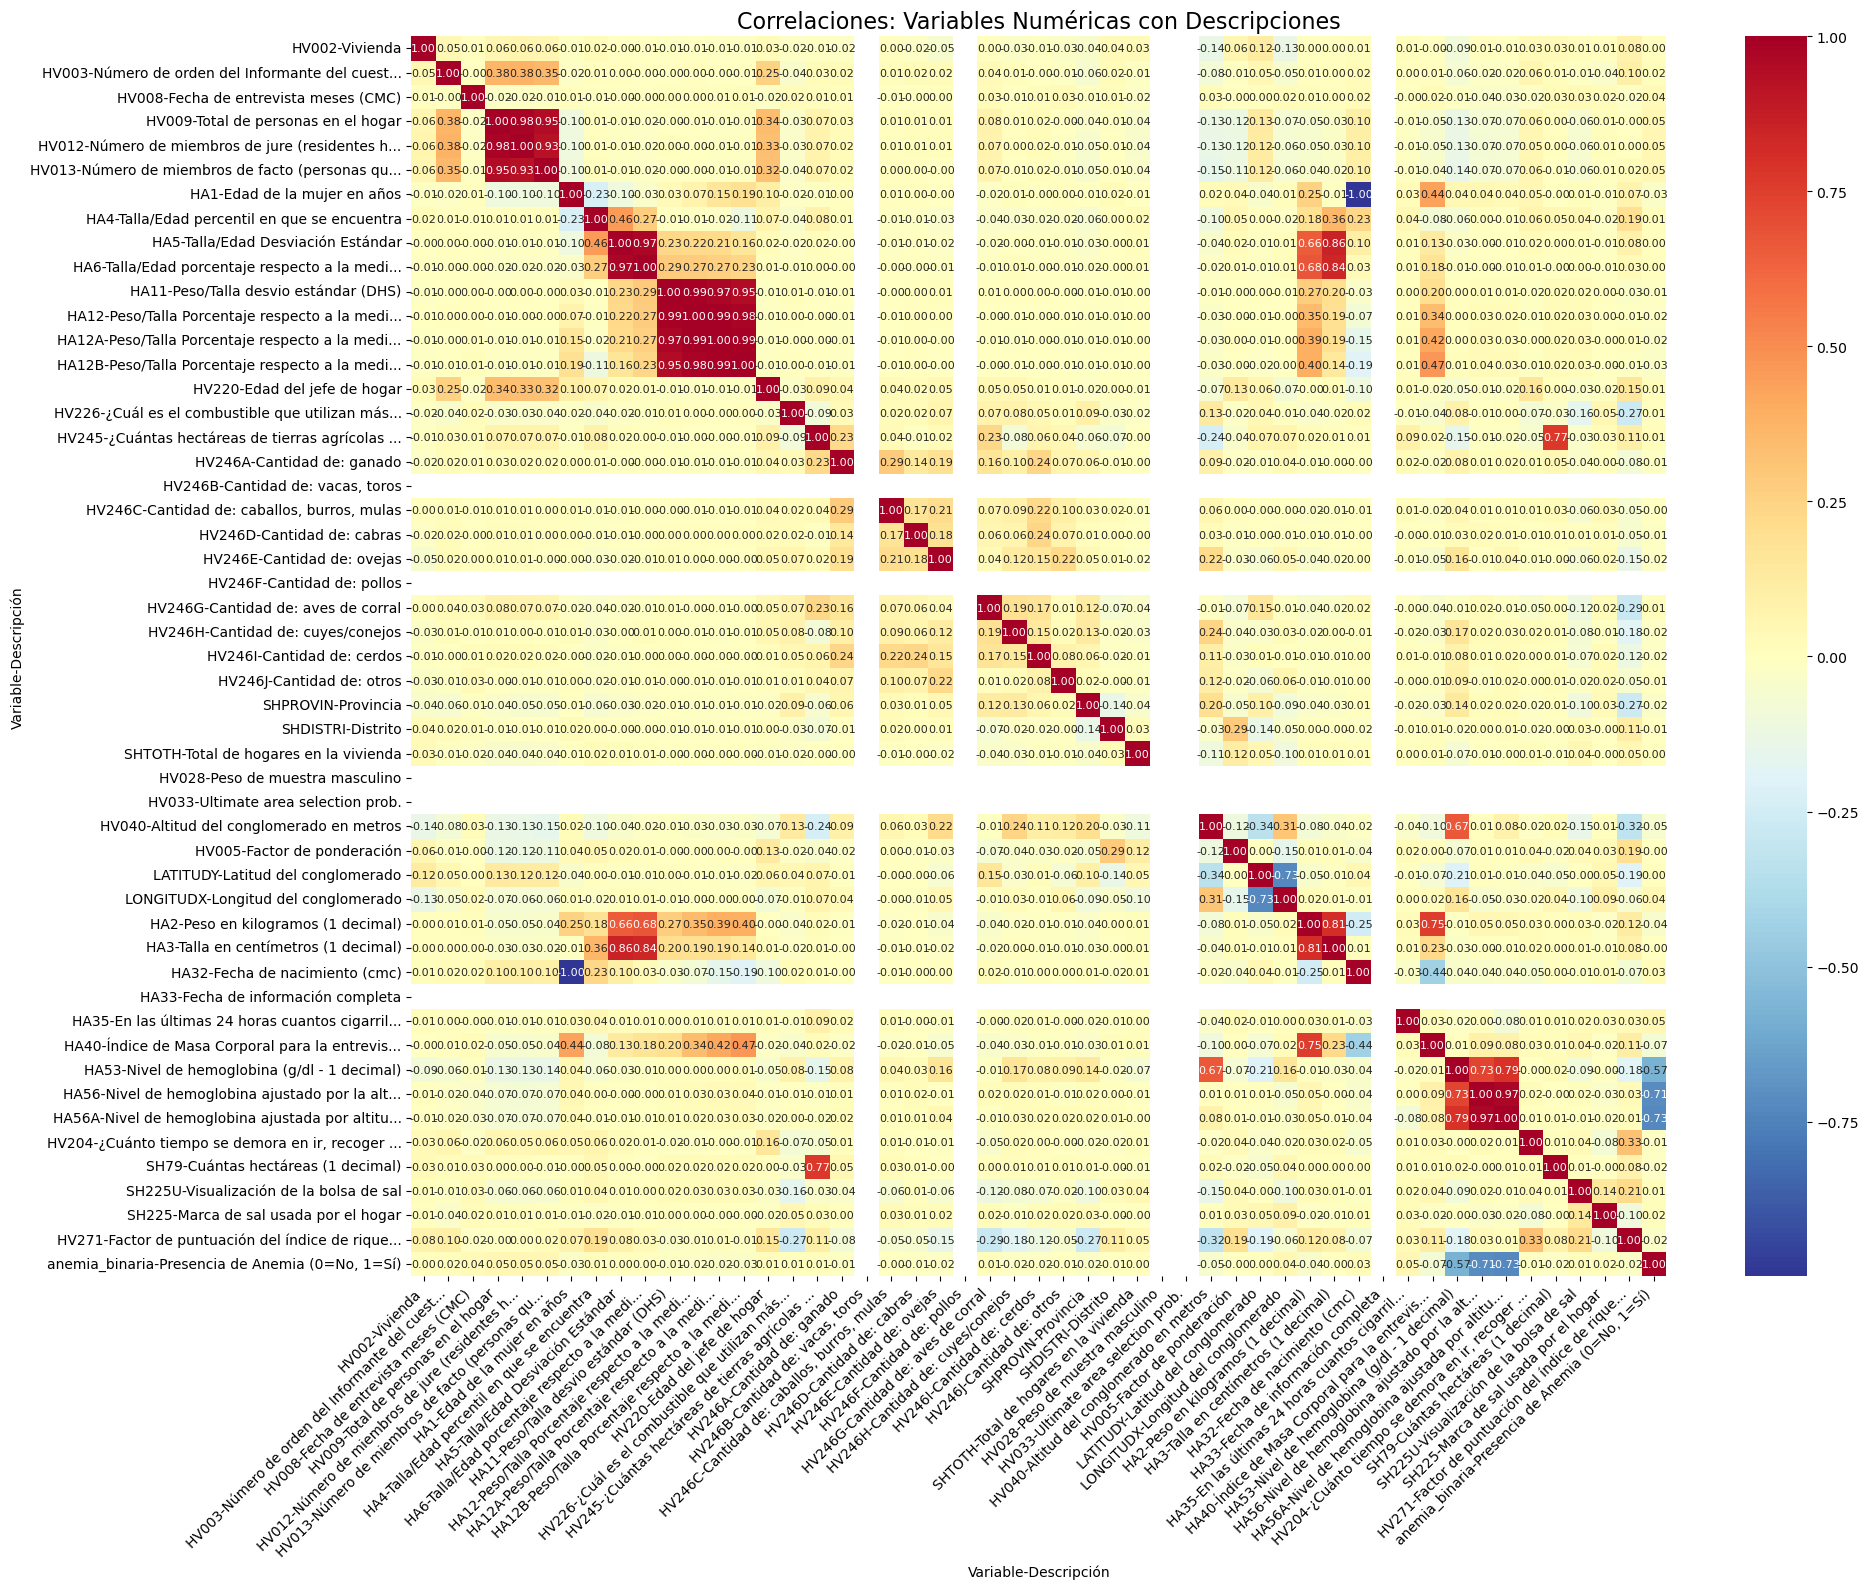

In [28]:

# Correlación con TODAS las variables numéricas disponibles
vars_numericas_disponibles = [var for var in variables_numericas if var in df_typed_clean.columns]
vars_numericas_disponibles.append('anemia_binaria')

# Crear matriz de correlación
corr_matrix = df_typed_clean[vars_numericas_disponibles].corr()

# Crear etiquetas para MultiIndex con descripciones
variables_labels = []
descripciones_labels = []

for var in vars_numericas_disponibles:
    variables_labels.append(var)
    if var == 'anemia_binaria':
        descripciones_labels.append('Presencia de Anemia (0=No, 1=Sí)')
    else:
        desc = dicc_union.get(var, 'Sin descripción')
        desc_truncada = desc[:40] + '...' if len(desc) > 40 else desc
        descripciones_labels.append(desc_truncada)

# Aplicar MultiIndex a la matriz de correlación
corr_matrix.index = pd.MultiIndex.from_arrays([variables_labels, descripciones_labels],
                                              names=['Variable', 'Descripción'])
corr_matrix.columns = pd.MultiIndex.from_arrays([variables_labels, descripciones_labels],
                                                names=['Variable', 'Descripción'])

plt.figure(figsize=(20,16))
sns.heatmap(corr_matrix, annot=True, cmap='RdYlBu_r', center=0, fmt='.2f',
            xticklabels=True, yticklabels=True, annot_kws={'size': 8})
plt.title("Correlaciones: Variables Numéricas con Descripciones", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

In [27]:
# Cruce de todas las variables categóricas con la variable objetivo anemia_binaria (sin display)
print("Cruce de variables categóricas vs anemia_binaria (porcentaje por fila):")

df_cat_clean = df_typed_clean.copy()
vars_cat = [v for v in variables_categoricas if v in df_cat_clean.columns and v != 'HA57A']

crosstabs_cat = {}

for var in vars_cat:
    ct = pd.crosstab(df_cat_clean[var], df_cat_clean['anemia_binaria'], normalize='index') * 100
    ct.columns = ['Sin anemia (%)', 'Con anemia (%)']
    ct.index.name = f"{var} ({dicc_union.get(var, 'Sin descripción')})"
    crosstabs_cat[var] = ct.round(2)
    print(f"\nVariable: {var} - {dicc_union.get(var, 'Sin descripción')}")
    print(ct.round(2).head())

Cruce de variables categóricas vs anemia_binaria (porcentaje por fila):

Variable: HV007 - Año de entrevista
                           Sin anemia (%)  Con anemia (%)
HV007 (Año de entrevista)                                
2024                                73.43           26.57

Variable: HV010 - Número de mujeres elegibles para entrevista individual
                                                    Sin anemia (%)  \
HV010 (Número de mujeres elegibles para entrevi...                   
0                                                            71.66   
1                                                            74.69   
2                                                            71.83   
3                                                            70.06   
4                                                            70.58   

                                                    Con anemia (%)  
HV010 (Número de mujeres elegibles para entrevi...                  
0             

In [26]:
# Ejemplo para acceder a la tabla completa de una variable:
tabla = crosstabs_cat['HV234']
display(tabla)

,Sin anemia (%),Con anemia (%)
HV234 (Prueba de yodo para sal),,
0,68.56,31.44
15,70.89,29.11
30,69.35,30.65
7,71.32,28.68
994,74.12,25.88
995,66.86,33.14


#### 3.4 Diagnóstico de calidad inicial 

,Valores faltantes
HV028,34482
HV033,34482
HV246B,34482
HV246F,34482
SH225U,28937
SH225,28922
HV245,27574
SH79,27203
grupo_edad,3408


,Variable,Min,Max,Valores únicos
0,HHID,325503101,705708801,25065
1,HV002,1,273,252
2,HV003,1,13,13
3,HV008,1489,1500,12
4,HV009,1,19,19
5,HV012,1,19,19
6,HV013,0,19,20
7,HV028,NaN,NaN,0
8,HV033,NaN,NaN,0
9,HV040,1,5032,1631


,Variable,Valores únicos,Valores
0,HV000,1,[PE6]
1,HV001,3249,"[3255, 3256, 3257, 3258, 3259, ..., 6508, 6509..."
2,HV002A,5,"[1, 2, 3, 5, 4] Categories (5, int64): [1, 2, ..."
3,HV004,3249,"[3255, 3256, 3257, 3258, 3259, ..., 6508, 6509..."
4,HV007,1,"[2024] Categories (1, int64): [2024]"
...,...,...,...
152,SH227,7,"['2', '3', '5', '1', '9', '6', '4'] Categories..."
153,QH227A,3,"['1', ' ', '2'] Categories (3, object): [' ', ..."
154,QH227B,7,"['1', ' ', '3', '5', '4', '7', '2'] Categories..."
155,HV270,5,"['2', '3', '4', '1', '5'] Categories (5, objec..."


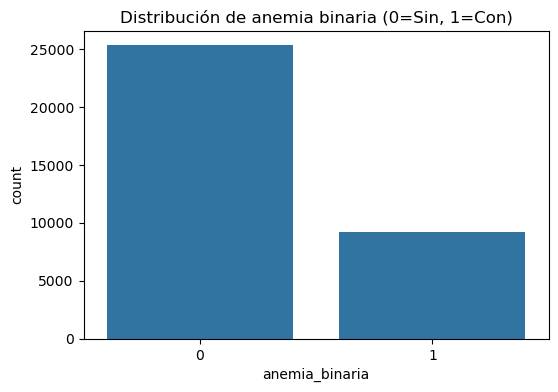

In [ ]:
#### 3.4 Diagnóstico de calidad inicial

import pandas as pd

# 1. Valores faltantes por variable (toda la data filtrada)
missing_clean = df_typed_clean.isnull().sum()
missing_clean_df = missing_clean[missing_clean > 0].sort_values(ascending=False).to_frame('Valores faltantes')
display(missing_clean_df)

# 2. Valores únicos y rangos para todas las variables numéricas
num_summary = []
for col in df_typed_clean.select_dtypes(include=[np.number]).columns:
    num_summary.append({
        'Variable': col,
        'Min': df_typed_clean[col].min(),
        'Max': df_typed_clean[col].max(),
        'Valores únicos': df_typed_clean[col].nunique()
    })
num_summary_df = pd.DataFrame(num_summary)
display(num_summary_df)

# 3. Valores únicos para todas las variables categóricas
cat_summary = []
for col in df_typed_clean.select_dtypes(include=['category', 'object']).columns:
    cat_summary.append({
        'Variable': col,
        'Valores únicos': df_typed_clean[col].nunique(),
        'Valores': df_typed_clean[col].unique()
    })
cat_summary_df = pd.DataFrame(cat_summary)
display(cat_summary_df)

# 4. Distribución de la variable objetivo (si existe)
if 'anemia_binaria' in df_typed_clean.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(x='anemia_binaria', data=df_typed_clean)
    plt.title("Distribución de anemia binaria (0=Sin, 1=Con)")
    plt.show()